# PHAS0056: Practical Machine Learning for Physicists: Week 5 Exercise: 

In [1]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Some style imports
import matplotlib.style 
import matplotlib as mpl

# Import some image handling/loading libraries
from scipy import ndimage

from scipy import linalg

# Added for a progress bar
from tqdm import tqdm
import imageio

#Set default figure size
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

# Useful for debugging problems
print(tf.__version__)

2.6.0


### 1) Training Nerual Network:

In [2]:
# The original handwritten digit MNIST
mnist = keras.datasets.mnist  

# Setting training and test data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalise training/ test images
train_images= train_images/np.max(train_images)
test_images= test_images/np.max(test_images)

In [3]:
# Set up neural network model 

# Sequential is a standard layered neural network
model = keras.Sequential([
    
    #Add a fully-connected (Dense) layer  of 128 nodes with 28x28 input nodes with reLU activation
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(32,activation='relu'),
    
    # A 10 node in the output layer for each number
    keras.layers.Dense(10) ])

# Compiling model with adam optimiser and cross entropy loss
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [4]:
# Train network with training images
history = model.fit(train_images, train_labels, batch_size=100, epochs=30, verbose=0)

# Test accuracy of trained network
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('The accuracy of the network is', test_acc)

The accuracy of the network is 0.96670001745224


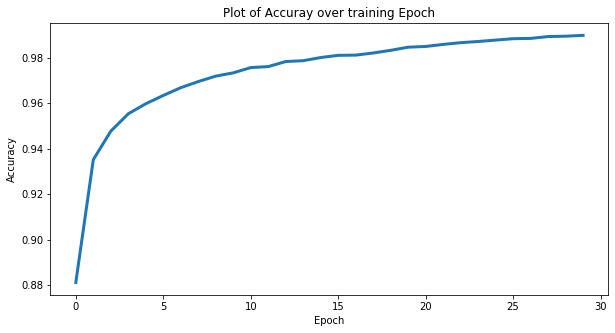

In [5]:
# Plotting accuracy over epochs
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(history.history['accuracy'], linewidth=3)

# Setting axis and labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Plot of Accuray over training Epoch')
plt.show()

### 2) Decomposing MNIST:

### PCA algorithm
First we flattern our MNIST data $N$ data points and  zero-mean the data such that $\mu=\frac{1}{N}\sum_i x_i =0$, then we will construct a matrix $X$ whose rows are the data points and columns the dimensions
$$X=\left[x_1,x_2,\cdots, x_N \right]^T$$

Then we can form the covariance matrix $\rho(x)$ which is a $p \times p$ symmetric matrix
$$\rho(x)=\frac{1}{N-1}X^TX$$
The diagonal elements of this matrix are the variances along each of the $p$-dimensions.

#### Eigenvector decomposition
We then decompose this matrix into its component eigenvectors; the eigenvectors $v$ and eigenvalues $\lambda$ of a sqaure matrix $A$ satsify the eigenvalue equation
$$A v = \lambda v$$

Let $V$ denote the matrix whose columns are $v$, and $\Lambda$ the diagonal matrix whose elements are the eigenvalues. Then the full family of eigenvalue equations can be written as
$$A V =  V \Lambda $$
where the ordering on the right is to make sure that the columnwise eigenvectors are multiplied by there corresponding eigenvalues. Now assumming our eigenvevctors are linearly independent then $V^{-1}$ exists and we can write
$$ A = V \Lambda V^{-1} $$


In [6]:
# Reshaping training images
X = np.reshape(train_images,(60000,784))

# Zero mean the training image data
mu_x = np.mean(X, axis=0)
x = X-mu_x

# Produce covaraince matrix by np.cov
rho = np.cov(x,rowvar=False)


# Using inbuilt functions to decompose the eigenvalues and vectors
# vals is a 1-D array of the eigenvalues in ascending order (we flip to get best) 
# vecs is a columnwise array of the normalised  eigenvectors 
# vecs[:,i] is the eigenvector correspondong to vals[i]

vals, vecs= linalg.eigh(rho)
vecs=np.flip(vecs)
vals=np.flip(vals)

### 3)  N-best PCA Testing
Having determined the eigenvectors we can reconstruct our test images using only a subset of the eigenvectors. Essenitally we construct a projection operator such that:
$$y = V^T V x$$
and then vary the number of eigenvectors including in the projection.

We achieve this by producing a projection, $P$, for desired image $x$:  
$$ P = x v $$

Then constuct the new image, $y_n$,  with reduced eigenvector components by only including $n$ components:
$$ y_n = P_n v^T_n $$

In [7]:
# Reshaping testing images
Y = np.reshape(test_images,(10000,784))

# Constructing projection operator for test images
Py = np.dot(Y,vecs)

# Constructing projection operator for training images
Px = np.dot(x,vecs)

In [8]:
# Max number of components for set of NPCA 
N = 784

# Incriments for number of NPCA
n = 8

# Dictonary to hold each NPCA
NPCA={}

for i in tqdm(range(int(N/n))):
    # Composing nPCA images
    pca = (np.dot(Py[:,0:n*i],vecs.T[0:n*i,:]))
    
    # Reshape and store images for large numbers data must be stired as uint8
    NPCA[n*i] = np.reshape(pca,[10000,28,28])

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  4.84it/s]


In [9]:
# Empty array to hold results 
results1 = np.zeros([len(NPCA)])

for i in tqdm(range(len(NPCA))):
    # Testing on each set of nPCA images in dic.
    test_loss, test_acc = model.evaluate( NPCA[i*n] , test_labels, verbose=0)
    
    # Store results
    results1[i] = test_acc

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [01:24<00:00,  2.72it/s]


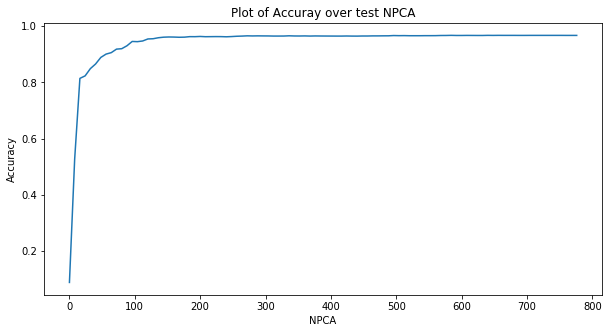

In [10]:
# Plotting accuray of model over noise of test image
fig,ax=plt.subplots(figsize=(10,5))
ax.plot( np.array(list(NPCA.keys())), results1 )


# Setting axis and labels
ax.set_xlabel('NPCA')
ax.set_ylabel('Accuracy')
ax.set_title('Plot of Accuray over test NPCA')

plt.show()

#### Comment:
-  This shows expected tend, the more components the better accuracy as closer to true image; the graph shows exponential character which is expected when looking at variation of images from origanal against the number of PCA indices (which is also exponential). At around 100 PCAs we can see the image is easily distinguishable. So only relative little number of components needed before peak accuracy which shows it's a simple image set

### 4) Retraining on 100 PCA: 


In [11]:
# Reconstructing training images with 100 PCAs
PCA100 = np.dot(Px[:,0:100],vecs.T[0:100,:]) + mu_x

# Reshaping images
PCA100 = np.reshape(PCA100,[60000,28,28])

# Train network with training images with 100PCA
history2 = model.fit(PCA100, train_labels, batch_size=100, epochs=30, verbose=0)

# Test accuracy of trained network
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('The accuracy of the network is', test_acc)

The accuracy of the network is 0.9642999768257141


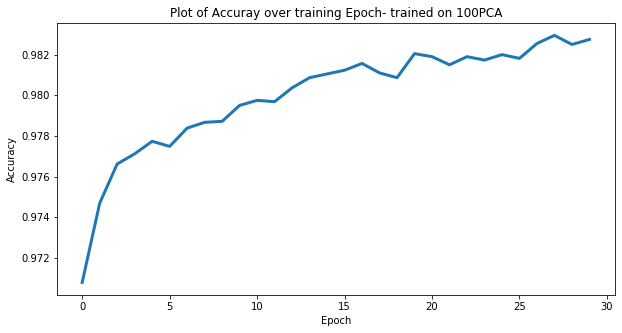

In [12]:
# Plotting accuracy over epochs
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(history2.history['accuracy'], linewidth=3)

# Setting axis and labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Plot of Accuray over training Epoch- trained on 100PCA')
plt.show()

In [13]:
# Empty array for results 
results2 = np.zeros([len(NPCA)])

for i in tqdm(range(len(NPCA))):
    # Testing on each set of nPCA images in dic.
    test_loss, test_acc = model.evaluate( NPCA[i*n] , test_labels, verbose=0)
    
    # Store results
    results2[i] = test_acc

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [01:20<00:00,  1.11it/s]


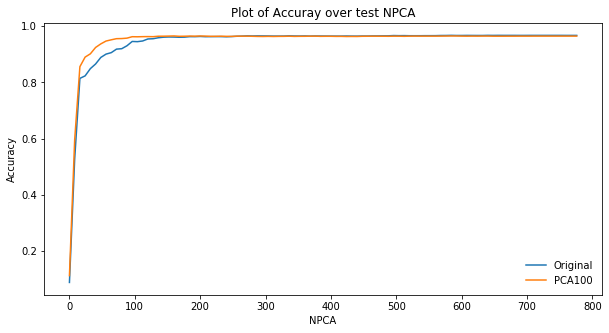

In [14]:
# Plotting accuray of model over noise of test image
fig,ax=plt.subplots(figsize=(10,5))
ax.plot( np.array(list(NPCA.keys())), results1, label = 'Original')
ax.plot( np.array(list(NPCA.keys())), results2, label = 'PCA100')

# Setting axis and labels
ax.set_xlabel('NPCA')
ax.set_ylabel('Accuracy')
ax.set_title('Plot of Accuray over test NPCA')
ax.legend()

plt.show()

#### Comment:
- Retraining shows it spike quicker, so better recognising with less components, as network is trained for less distinguishable components. Therefore sharper accuracy of network.

### 6) Retraining for best 20PCA:

In [16]:
# Reconstructing training images with 20 PCAs
PCA20 = np.dot(Px[:,0:20],vecs.T[0:20,:]) + mu_x

# Reshaping images
PCA20 = np.reshape(PCA20,[60000,28,28])

# Train network with training images with no noise
history3 = model.fit(PCA20, train_labels, batch_size=100, epochs=30, verbose=0)

# Test accuracy of trained network
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('The accuracy of the network is', test_acc)

The accuracy of the network is 0.9269000291824341


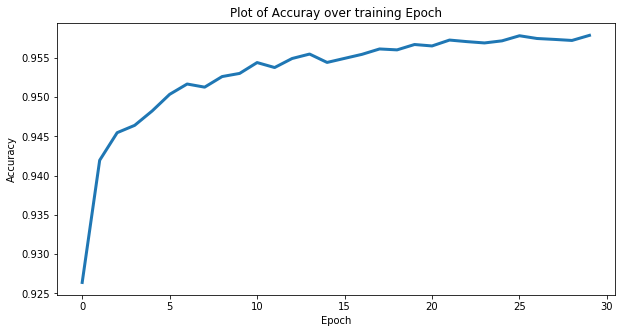

In [17]:
# Plotting accuracy over epochs
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(history3.history['accuracy'], linewidth=3)

# Setting axis and labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Plot of Accuray over training Epoch')
plt.show()

In [18]:
# Array to hold results
results3 = np.zeros([len(NPCA)])

for i in tqdm(range(len(NPCA))):
    # Testing on each set of nPCA images in dic.
    test_loss, test_acc = model.evaluate( NPCA[i*n] , test_labels, verbose=0)
    
    # Store results
    results3[i] = test_acc

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [01:06<00:00,  1.02it/s]


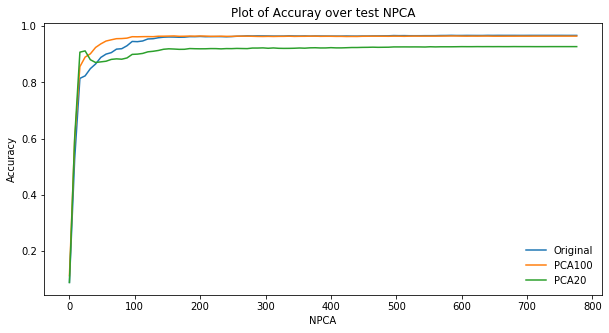

In [19]:
# Plotting accuray of model over noise of test image
fig,ax=plt.subplots(figsize=(10,5))
ax.plot( np.array(list(NPCA.keys())), results1, label = 'Original' )
ax.plot( np.array(list(NPCA.keys())), results2, label = 'PCA100' )
ax.plot( np.array(list(NPCA.keys())), results3, label = 'PCA20' )


# Setting axis and labels
ax.set_xlabel('NPCA')
ax.set_ylabel('Accuracy')
ax.set_title('Plot of Accuray over test NPCA')
ax.legend()

plt.show()

#### Comment:
- Retraining shows again it spike quicker, so better recognising with less components, but loses overall accuracy as can't distinguish when full components, it has learnt how to recognize the base components only and unlearned some of the recognition of full imag. We see peak accuracy around 20 PCA components

## Further Exploration with Normalisation:

### Setting up model again

In [20]:
# Sequential is a standard layered neural network
model = keras.Sequential([
    
    #Add a fully-connected (Dense) layer  of 128 nodes with 28x28 input nodes with reLU activation
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(32,activation='relu'),
    
    # A 10 node in the output layer for each number
    keras.layers.Dense(10) ])

# Compiling model with adam optimiser and cross entropy loss
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train network with training images
history = model.fit(train_images, train_labels, batch_size=100, epochs=30, verbose=0)

# Test accuracy of trained network
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('The accuracy of the network is', test_acc)

The accuracy of the network is 0.9689000248908997


### New nPCA Test images normalised and recentred:

In [21]:
# Max number of components for set of NPCA 
N = 784

# Incriments for number of NPCA
n = 8

# Dictonary to hold each NPCA
NPCA={}

for i in tqdm(range(int(N/n))):
    # Composing nPCA images
    pca = (np.dot(Py[:,0:n*i],vecs.T[0:n*i,:]))
    
    # Recenter and normalise values 
    pca -= np.min(pca, axis=1)[:,None]
    pca /= np.max(pca, axis=1)[:,None]
    
    # Reshape and store images for large numbers data must be stired as uint8
    NPCA[n*i] = np.reshape(pca,[10000,28,28])

  0%|                                                                                           | 0/98 [00:00<?, ?it/s]C:\Users\Student\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  3.35it/s]


### New PCA training images normalised and recentred:

In [22]:
# Reconstructing training images with 100 PCAs
PCA100 = np.dot(Px[:,0:100],vecs.T[0:100,:]) + mu_x

# Recenter and normalise values 
PCA100 -= np.min(PCA100, axis=1)[:,None]
PCA100 /= np.max(PCA100, axis=1)[:,None]

# Reshaping images
PCA100 = np.reshape(PCA100,[60000,28,28])

# Reconstructing training images with 20 PCAs
PCA20 = np.dot(Px[:,0:20],vecs.T[0:20,:]) + mu_x

# Recenter and normalise values 
PCA20-= np.min(PCA20, axis=1)[:,None]
PCA20 /= np.max(PCA20, axis=1)[:,None]

# Reshaping images
PCA20 = np.reshape(PCA20,[60000,28,28])

### Plots to compare normalised and un-normalised images

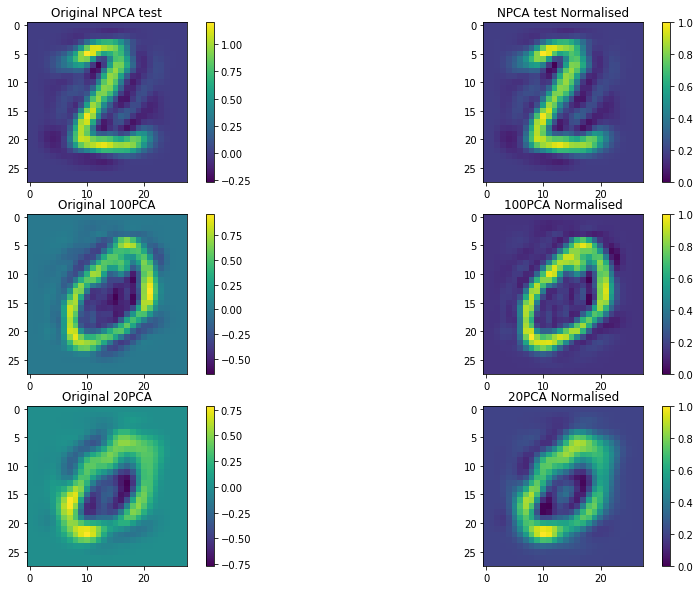

In [36]:
# Plotting images
whichImage=1
Nn= 40

fig,ax=plt.subplots(3,2, figsize= (15,10) )

im1= ax[0,0].imshow(np.reshape(np.dot(Py[:,0:Nn],vecs.T[0:Nn,:]),[10000,28,28])[whichImage])
ax[0,0].set_title("Original NPCA test")
fig.colorbar(im1, ax= ax[0,0])

im2= ax[0,1].imshow(NPCA[Nn][whichImage])
ax[0,1].set_title('NPCA test Normalised')
fig.colorbar(im2, ax= ax[0,1])

im3= ax[1,0].imshow(np.reshape(np.dot(Px[:,0:100],vecs.T[0:100,:]),[60000,28,28])[whichImage])
ax[1,0].set_title("Original 100PCA")
fig.colorbar(im3, ax= ax[1,0])

im4= ax[1,1].imshow(PCA100[whichImage])
ax[1,1].set_title('100PCA Normalised')
fig.colorbar(im4, ax= ax[1,1])

im5= ax[2,0].imshow(np.reshape(np.dot(Px[:,0:20],vecs.T[0:20,:]),[60000,28,28])[whichImage])
ax[2,0].set_title("Original 20PCA")
fig.colorbar(im5, ax= ax[2,0])

im6= ax[2,1].imshow(PCA20[whichImage])
ax[2,1].set_title('20PCA Normalised')
fig.colorbar(im6, ax= ax[2,1])
plt.show()

### Re-testing and training model:

In [31]:
# Empty array to hold results 
results1 = np.zeros([len(NPCA)])

for i in tqdm(range(len(NPCA))):
    # Testing on each set of nPCA images in dic.
    test_loss, test_acc = model.evaluate( NPCA[i*n] , test_labels, verbose=0)
    
    # Store results
    results1[i] = test_acc

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [01:28<00:00,  1.08it/s]


In [32]:
# Train network with training images with 100PCA
history2 = model.fit(PCA100, train_labels, batch_size=100, epochs=30, verbose=0)

# Test accuracy of trained network
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('The accuracy of the network is', test_acc)

# Empty array for results 
results2 = np.zeros([len(NPCA)])

for i in tqdm(range(len(NPCA))):
    # Testing on each set of nPCA images in dic.
    test_loss, test_acc = model.evaluate( NPCA[i*n] , test_labels, verbose=0)
    
    # Store results
    results2[i] = test_acc

The accuracy of the network is 0.9621999859809875


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [01:13<00:00,  1.04it/s]


In [33]:
# Train network with training images with no noise
history3 = model.fit(PCA20, train_labels, batch_size=100, epochs=30, verbose=0)

# Test accuracy of trained network
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('The accuracy of the network is', test_acc)

# Array to hold results
results3 = np.zeros([len(NPCA)])

for i in tqdm(range(len(NPCA))):
    # Testing on each set of nPCA images in dic.
    test_loss, test_acc = model.evaluate( NPCA[i*n] , test_labels, verbose=0)
    
    # Store results
    results3[i] = test_acc

The accuracy of the network is 0.9334999918937683


100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [01:15<00:00,  1.05it/s]


### Plot new normalised results:

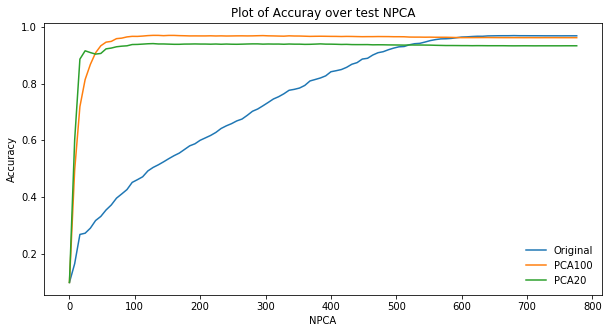

In [34]:
# Plotting accuray of model over noise of test image
fig,ax=plt.subplots(figsize=(10,5))
ax.plot( np.array(list(NPCA.keys())), results1, label = 'Original' )
ax.plot( np.array(list(NPCA.keys())), results2, label = 'PCA100' )
ax.plot( np.array(list(NPCA.keys())), results3, label = 'PCA20' )


# Setting axis and labels
ax.set_xlabel('NPCA')
ax.set_ylabel('Accuracy')
ax.set_title('Plot of Accuray over test NPCA')
ax.legend()

plt.show()

#### Comment:
- Using normalised images we have a intresting behaviour of the origanal test, showing near linear behaviour over the range. Although still partially parabolic this seems unusual change.